In [1]:
import os, glob, time, h5py, warnings, sys
import os.path
import multiprocessing as mp
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit

from liblibra_core import *
import util.libutil as comn

import libra_py
from libra_py import units, data_conv, dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_plot
#import libra_py.data_savers as data_savers
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.data_visualize
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot


#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')


/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 1. Plotting the populations

../Exact/EXACT-model5-mix
TSH-method0-model5-dt4.0
TSH-method0-model5-dt40.0
TSH-method1-model5-dt4.0
TSH-method1-model5-dt40.0
TSH-method2-model5-dt4.0
TSH-method2-model5-dt40.0
TSH-method3-model5-dt4.0
TSH-method3-model5-dt40.0


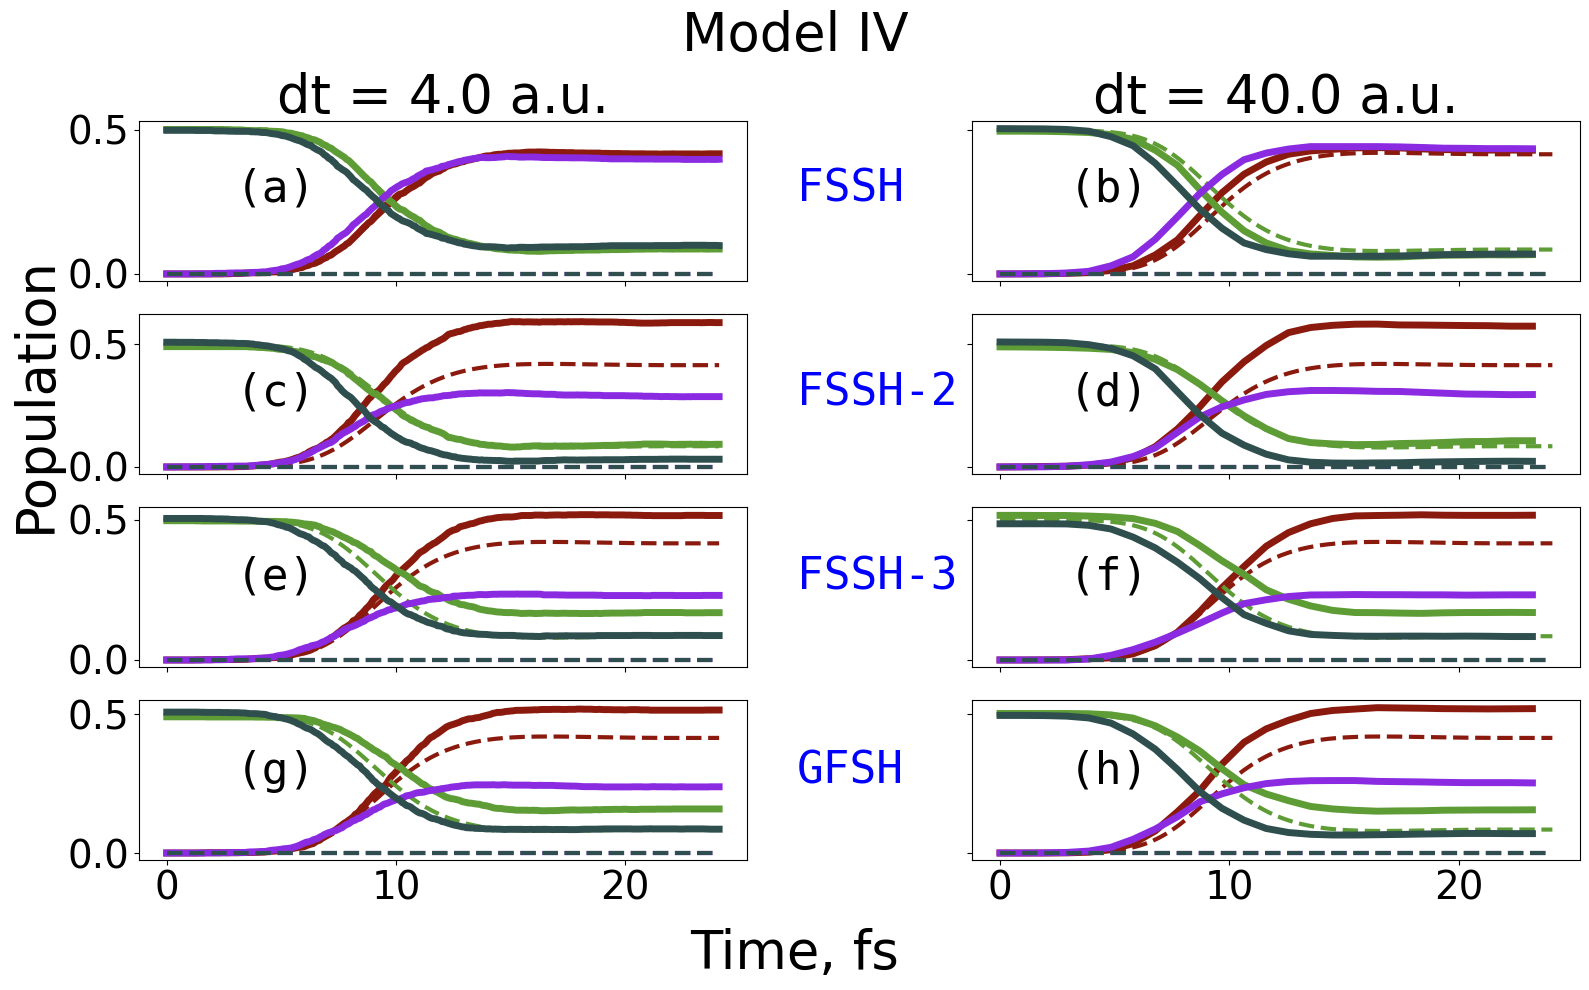

In [3]:
plt.rc('axes', titlesize=38)      # fontsize of the axes title
plt.rc('axes', labelsize=38)      # fontsize of the x and y labels
plt.rc('legend', fontsize=26)     # legend fontsize
plt.rc('xtick', labelsize=28)     # fontsize of the tick labels
plt.rc('ytick', labelsize=28)     # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)


font = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 36,
        }

#======== Initial conditions and models ==============


#models = [0, 1, 2, 3, 4]
models = [5]
models_map = { "0":"I", "1":"II", "2":"IV", "3":"III", "4":"V", "5":"IV"}

#methods = [0, 1, 2, 3]
methods = [0, 1, 2, 3]
methods_map = { "0":"FSSH", "1":"FSSH-2", "2":"FSSH-3", "3":"GFSH"}

label_map = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

for c, model_indx in enumerate(models):
        
    fig, ax = plt.subplots(4, 2, figsize=(16, 10), sharey="row", sharex="col")
    
    
    #=================== Exact data =========================
    prf = F"../Exact/EXACT-model{model_indx}-mix"        
    print(F"{prf}")
         
    pop_adi, t = None, None
    with h5py.File(F"{prf}/data.hdf", 'r') as F:
        pop_adi = np.array(F["pop_adi/data"][0:250, :, 0])                
        t = np.array(F['time/data'][0:250]) * units.au2fs        
        
    
    #=================== TSH data =========================
    for c2, method_indx in enumerate(methods):        
        prf1 = F"TSH-method{method_indx}-model{model_indx}-dt4.0"        
        print(F"{prf1}")
         
        sh_pop_adi1, t1 = None, None
        with h5py.File(F"{prf1}/mem_data.hdf", 'r') as F:
            sh_pops_adi1 = np.array(F['sh_pop_adi/data'][:,:]) 
            t1 = np.array(F['time/data'][:]) * units.au2fs                   

        
        prf2 = F"TSH-method{method_indx}-model{model_indx}-dt40.0"        
        print(F"{prf2}")
         
        sh_pop_adi2, t2 = None, None
        with h5py.File(F"{prf2}/mem_data.hdf", 'r') as F:
            sh_pops_adi2 = np.array(F['sh_pop_adi/data'][:,:]) 
            t2 = np.array(F['time/data'][:]) * units.au2fs                   
            
        nstates = sh_pops_adi1.shape[1]

            
        #=================== Now compute the errors =========================        
        for i in range(nstates):
            clrs_index = libra_py.data_visualize.clrs_index[i % 10 ]        
            ax[c2, 0].plot(t1, sh_pops_adi1[:, i], color=libra_py.data_visualize.colors[ clrs_index ], label=F"P_{i}", lw=5)            
            ax[c2, 1].plot(t2, sh_pops_adi2[:, i], color=libra_py.data_visualize.colors[ clrs_index ], label=F"P_{i}", lw=5)
            
            ax[c2, 0].plot(t, pop_adi[:, i], color=libra_py.data_visualize.colors[ clrs_index ], label=F"$P_{i}$", ls="--", lw=3)
            ax[c2, 1].plot(t, pop_adi[:, i], color=libra_py.data_visualize.colors[ clrs_index ], label=F"$P_{i}$", ls="--", lw=3)
            
        panel = label_map[ 2*c2 + 0]
        ax[c2, 0].text(3.0, 0.25, panel, fontsize=32, fontname='Monospace', color='black')
            
        panel = label_map[ 2*c2 + 1]
        ax[c2, 1].text(3.0, 0.25, panel, fontsize=32, fontname='Monospace', color='black')
            
        ax[c2, 0].text(27.5, 0.25, methods_map[ str(method_indx) ], fontsize=32, fontname='Monospace', color='blue')
         
        ax[0,0].set_title("dt = 4.0 a.u.")
        ax[0,1].set_title("dt = 40.0 a.u.")
                
        #ax[0,0].set_ylabel("Population")
        ax[1,0].set_ylabel("Population")
        
        
    
    #for ax_ in fig.get_axes():
    #    ax_.label_outer()
    
    fig.suptitle(F'Model { models_map[ str(model_indx)] }', size=38) 
    fig.supxlabel("Time, fs", size=38)
    
    #plt.legend()
    plt.tight_layout()    
    plt.savefig(F'TSH-model{model_indx}.png')
    
    